In [1]:
# Import numpy and matplotlib, and use jupyter magic to
# get plots directly in notebook
import numpy as np
import matplotlib
%matplotlib inline
from matplotlib import pyplot as plt
from scipy.sparse import diags

In [2]:
import sys
sys.path.append('../scripts/')
from eulerian_functions import setup_AD_matrices, setup_FL_matrices, EulerianSystemParameters, velocity_vector_function
from eulerian_functions import thomas, get_rho_vectors, psi_vector_function

from eulerian_case2 import Crank_Nicolson_LHS, flux_limiter_reaction_term_function

# Case parameters

In [3]:
#### Hard-coded parameters for this case ####
# Total depth
Zmax = 50
# Simulation time
Tmax = 12*3600

# For this case, we use a speed distribution directly, taken from
# Table 3 in Sundby (1983).
# Mean speed = 0.96 mm/s
# Standard deviation = 0.38 mm/s
# Truncated at +/- 2*sigma
mean_speed = 0.0 * 1e-3
std_dev_speed = 0.38 * 1e-3
Vmin = mean_speed - 2*std_dev_speed
Vmax = mean_speed + 2*std_dev_speed
speed_distribution = lambda v: np.exp(-0.5*((v - mean_speed)/std_dev_speed)**2) / (std_dev_speed*np.sqrt(2*np.pi))
speed_distribution = lambda v: np.ones_like(v) / (4*std_dev_speed)


# Initial condition:
# Normal distribution with mean mu and standard deviation sigma
sigma_IC = 15
mu_IC = 25
pdf_IC = lambda z: np.exp(-0.5*((z - mu_IC)/sigma_IC)**2) / (sigma_IC*np.sqrt(2*np.pi))


##################################
####   Diffusivity profiles   ####
##################################

# Constant diffusivity
K_A = lambda z: 1e-3*np.ones(len(z))

# Fitted to results of GOTM simulation
#alpha, beta, zeta, z0 = (0.00636, 0.088, 1.54, 1.3)
#K_B = lambda z: alpha*(z+z0)*np.exp(-(beta*(z+z0))**zeta)
K_B = lambda z: 1e-3 + 1e-2*np.sin(z*np.pi/Zmax)



####################################################
####   Populate object with system parameters   ####
####################################################

params = EulerianSystemParameters(
        Zmax = Zmax, # Max depth of water column
        Nz = 1000, # Number of cells in z-direction
        Tmax = Tmax, # Simulation time
        dt = 300, # timestep
        Vmin = Vmin, # Minimum speed
        Vmax = Vmax, # maximum speed
        Nclasses = 3, # Number of speed classes
        speed_distribution = speed_distribution, # speed density
    )

# Obtain matrices from new code

In [4]:
# Evaluate diffusivity function at cell faces
K_vec = K_A(params.z_face)
# Arrays of velocities for all cells and all classes
v_plus = np.maximum(velocity_vector_function(params), 0)
v_minus = np.minimum(velocity_vector_function(params), 0)

# Initial concentration
C0 = pdf_IC(params.z_cell)[:,None] * params.mass_fractions[None,:]

# Set up matrices encoding advection and diffusion
# (these are tri-diagonal, and constant in time)
L_AD, R_AD = setup_AD_matrices(params, K_vec, v_minus, v_plus)
L_FL, R_FL = setup_FL_matrices(params, v_minus, v_plus, C0)

# Obtain LHS matrix from old code

In [5]:
# z_cell, dz, NJ, NK, r_sans_D, CFL_sans_v, diffusivity_vector, velocity_vector_minus, velocity_vector_plus
L_old = diags(Crank_Nicolson_LHS(
    params.z_cell,
    params.dz,
    params.Nz,
    params.Nclasses,
    params.dt/params.dz**2,
    params.dt/params.dz,
    K_vec[:,None] * np.ones((params.Nz+1, params.Nclasses)),
    v_minus,
    v_plus
), offsets = (-1, 0, 1))

# Check that the three diagonals are equal in all elements

In [6]:
for i in (-1,0,1):
    print(f'Diagonal {i:>2} matches: {np.allclose(L_AD.diagonal(i), L_old.diagonal(i))}')

print('Largest difference: ', np.amax(np.abs((L_AD - L_old).todense())))

Diagonal -1 matches: True
Diagonal  0 matches: True
Diagonal  1 matches: True
Largest difference:  0.0


# Get dot product of C and LHS flux limiter from new code

In [7]:
LHS_FL = L_FL.dot(C0.T.flatten()).reshape(params.Nclasses, params.Nz).T

# Get dot product of C and LHS flux limiter from old code

In [8]:
LHS_FL_old = flux_limiter_reaction_term_function(
    C0,
    params.Nz,
    params.Nclasses,
    params.dt/params.dz**2,
    params.dt/params.dz,
    v_minus,
    v_plus
)

# Confirm that the two dot products are equal

In [9]:
print('All elements match: ', np.allclose(LHS_FL, 0.5*LHS_FL_old))

print('Largest difference: ', np.amax(np.abs(LHS_FL - 0.5*LHS_FL_old)))

All elements match:  True
Largest difference:  3.6767317960145025e-18


# Loading and looking at results

In [63]:
profile = 'B'

# Constant diffusivity
K_A = lambda z: 1e-3*np.ones(len(z))
# Variable but symmetric diffusivity
K_B = lambda z: 1e-3 + 1e-2*np.sin(z*np.pi/Zmax)

if profile == 'A':
    K_vec = K_A(params.z_face)
else:
    K_vec = K_B(params.z_face)

C = np.load(f'../data/Case0_K_{profile}_block_Nclasses=3_NJ=1000_dt=300.npy')
print('C.shape = ', C.shape)

C.shape =  (1000, 433, 3)


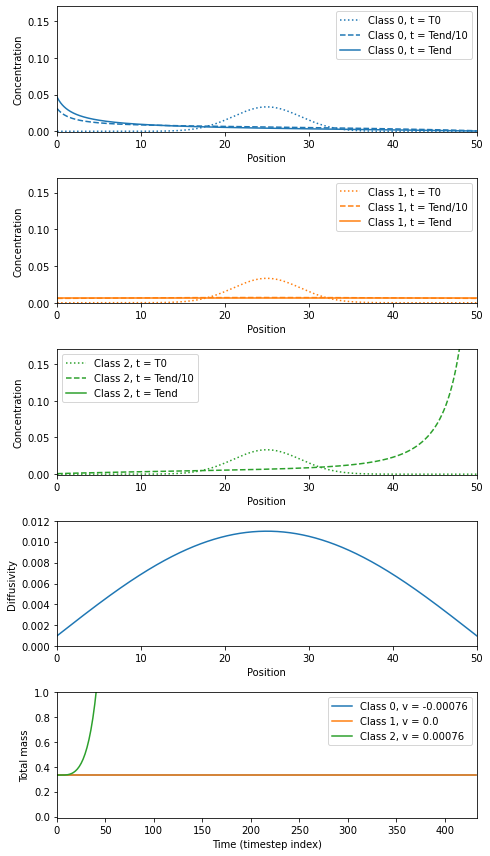

In [64]:
fig, ax = plt.subplots(nrows = 5, figsize = (7,12))

for i in (0, 1, 2):
    speeds = [-2*0.38e-3, 0.0, 2*0.38e-3]
    l, = ax[4].plot(params.dz*np.sum(C[:,:,i], axis = (0)), label = f'Class {i}, v = {speeds[i]}')
    ax[i].plot(params.z_cell, C[:,0,i], ':', c = l.get_color(), label = f'Class {i}, t = T0')
    ax[i].plot(params.z_cell, C[:,45,i], '--', c = l.get_color(), label = f'Class {i}, t = Tend/10')
    ax[i].plot(params.z_cell, C[:,-1,i], c = l.get_color(), label = f'Class {i}, t = Tend')
    ax[i].legend()
    ax[i].set_ylim(-0.001, 0.17)
    ax[i].set_xlim(0, params.Zmax)
    ax[i].set_xlabel('Position')
    ax[i].set_ylabel('Concentration')
    
ax[3].plot(params.z_face, K_vec)
ax[3].set_ylabel('Diffusivity')
ax[3].set_xlabel('Position')
ax[3].set_ylim(0.0, 0.012)
ax[3].set_xlim(0, params.Zmax)

ax[4].set_ylabel('Total mass')
ax[4].set_xlabel('Time (timestep index)')
ax[4].set_ylim(-0.01, 1)
ax[4].set_xlim(0, C.shape[1])
ax[4].legend()

plt.tight_layout()

if profile == 'A':
    plt.savefig('Symmetric_test_3_classes_constant_diffusivity.png', dpi = 240)
else:
    plt.savefig('Symmetric_test_3_classes_variable_diffusivity.png', dpi = 240)